In [1]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams
import random

In [2]:
# Load data from pickle file
with open('/Users/naveenverma/Desktop/NewStart/Dataset/a1-data/imdb_review.pickle', 'rb') as f:
    data = pickle.load(f)

# Tokenize the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
indexed_data = tokenizer.texts_to_sequences(data)

In [3]:
def generate_skipgram_pairs(indexed_data, vocab_size, window_size, num_negative_samples):
    skipgram_pairs = []
    for review in indexed_data:
        for i, center_word in enumerate(review):
            context = [review[j] for j in range(max(0, i - window_size), min(len(review), i + window_size + 1)) if j != i]
            for context_word in context:
                # Positive sample
                skipgram_pairs.append((center_word, context_word, 1))
                # Negative samples
                for _ in range(num_negative_samples):
                    negative_word = random.randint(1, vocab_size - 1)
                    while negative_word == center_word or negative_word == context_word:
                        negative_word = random.randint(1, vocab_size - 1)
                    skipgram_pairs.append((center_word, negative_word, 0))
    return skipgram_pairs


In [4]:
vocab_size = len(tokenizer.word_index) + 1
window_size = 2
num_negative_samples = 5
skipgram_pairs = generate_skipgram_pairs(indexed_data, vocab_size, window_size, num_negative_samples)

In [5]:
batch_size = 128
embedding_dim = 100

# Create tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((np.array(skipgram_pairs[0]), np.array(skipgram_pairs[1])))
dataset = dataset.shuffle(buffer_size=len(skipgram_pairs[0])).batch(batch_size)

In [6]:
# Define the Skip-gram model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Train the model
model.fit(dataset, epochs=5)

# Get the trained embeddings
embeddings = model.layers[0].get_weights()[0]

# Save embeddings to a file
np.save("word_embeddings.npy", embeddings)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 11.5360
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 11.5312
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 11.5263
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 11.5214
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 11.5163


In [7]:
# Define cosine similarity function
def cosine_similarity(vector, matrix):
    dot_product = np.dot(matrix, vector)
    vector_norm = np.linalg.norm(vector)
    matrix_norm = np.linalg.norm(matrix, axis=1)
    similarity = dot_product / (vector_norm * matrix_norm)
    return similarity

# Implement k-nearest neighbors algorithm using cosine similarity
def knn(target_vector, matrix, k):
    similarities = cosine_similarity(target_vector, matrix)
    nearest_indices = np.argsort(similarities)[::-1][:k]
    return nearest_indices

# Load the trained embeddings from the file
embeddings = np.load("word_embeddings.npy")

# Example target vector
target_vector = embeddings[0]

# Number of nearest neighbors to find
k = 5

# Find the indices of the k-nearest neighbors
nearest_indices = knn(target_vector, embeddings, k)
print("Indices of nearest neighbors:", nearest_indices)

Indices of nearest neighbors: [    0  8245 60797 97359 22249]


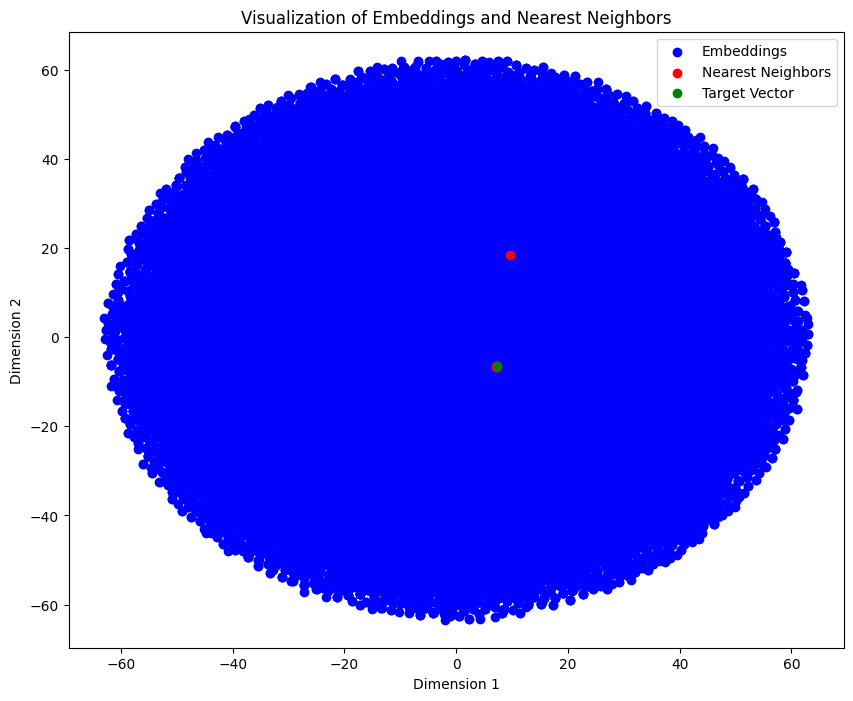

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# t-SNE
reducer = TSNE(n_components=2)

# Reduce the dimensionality of the embeddings
reduced_embeddings = reducer.fit_transform(embeddings)

# Plot the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', label='Embeddings')

# Plot the nearest neighbors
nearest_neighbors = reduced_embeddings[nearest_indices]
plt.scatter(nearest_neighbors[:, 0], nearest_neighbors[:, 1], color='red', label='Nearest Neighbors')

# Plot the target vector
plt.scatter(reduced_embeddings[0, 0], reduced_embeddings[0, 1], color='green', label='Target Vector')

# Add labels and legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Visualization of Embeddings and Nearest Neighbors')
plt.legend()

# Show plot
plt.show()

Conclusion -
1 - The code successfully implements a skip-gram model for generating word embeddings.
2 - Loss value is 11.5163.
3 - The trained model produces word embeddings, which are vector representation of words in continuous vector space.
4 - Cosine Similarity Function calculates the cosine similarity between a target vector and a matrix of vectors.
5 - K-Nearest Neighbors - The knn function uses the cosine similarity function to find the indices of the k-nearest neighbours to a given target vector in a matrix of vectors.